**Download Dataset From Kaggle**


In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
#upload kaggle json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rokayashaban","key":"21fe30edc9691dbe0b28d6ba0bf6269c"}'}

In [ ]:
#creat a kaggle folder
! mkdir ~/.kaggle

In [ ]:
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# to list all datasets in kaggle
! kaggle datasets list

ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset          Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           1002         43  1.0              
arnavsmayan/netflix-userbase-dataset                              Netflix Userbase Dataset                             25KB  2023-07-04 07:38:41           1080         29  1.0              
aaditshukla/flipkart-fasion-products-dataset                       Ecommerce Product dataset                           15MB  2023-07-04 05:44:07            587         25  0.9411765        
arthurchongg/imdb-top-1000-movies                 

In [ ]:
!kaggle datasets download -d hanimohamed/nih-chest-x-ray-14-224x224-resized-updated

100% 2.89G/2.89G [02:44<00:00, 22.6MB/s]
100% 2.89G/2.89G [02:44<00:00, 18.8MB/s]


In [ ]:
%ls

kaggle.json  nih-chest-x-ray-14-224x224-resized-updated.zip  sample_data/


In [ ]:
!unzip /content/nih-chest-x-ray-14-224x224-resized-updated.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/Pleural_Thickening/00009516_003.png  
  inflating: Dataset/train/Pleural_Thickening/00009523_008.png  
  inflating: Dataset/train/Pleural_Thickening/00009535_001.png  
  inflating: Dataset/train/Pleural_Thickening/00009563_000.png  
  inflating: Dataset/train/Pleural_Thickening/00009600_007.png  
  inflating: Dataset/train/Pleural_Thickening/00009600_017.png  
  inflating: Dataset/train/Pleural_Thickening/00009606_006.png  
  inflating: Dataset/train/Pleural_Thickening/00009606_009.png  
  inflating: Dataset/train/Pleural_Thickening/00009606_010.png  
  inflating: Dataset/train/Pleural_Thickening/00009606_011.png  
  inflating: Dataset/train/Pleural_Thickening/00009641_001.png  
  inflating: Dataset/train/Pleural_Thickening/00009649_000.png  
  inflating: Dataset/train/Pleural_Thickening/00009658_000.png  
  inflating: Dataset/train/Pleural_Thickening/00009658_002.png  
  inflating: Dataset/train/Pleural_Thic

# Image classification

This tutorial shows how to classify images of Chest Diseases using a `tf.

---

keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

.

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

In [ ]:
import pathlib
import pandas as pd
dataset_url = "/content/Dataset"
data_dir ="/content/Dataset/train"
data_dir = pathlib.Path(data_dir).with_suffix('')




This tutorial uses a dataset of about 112,120 photos of Chest Desiese . The dataset contains fifteen sub-directories, one per class:

```
Chest Desiese/
Cardiomegaly/
Emphysema/
Effusion/
Hernia/
Infiltration/
Mass/
Nodule/
Atelectasis/
Pneumothorax/
Pleural_Thickening/
Fibrosis/
Edema/
Consolidation/
```

After downloading, you should now have a copy of the dataset available. There are 104470 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


104470


## Here are some Chest Diseases:

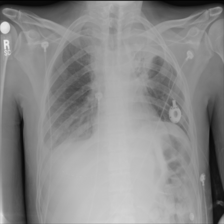

In [ ]:
Atelectasis = list(data_dir.glob('Atelectasis/*'))
PIL.Image.open(str(Atelectasis[0]))

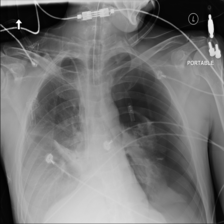

In [ ]:
PIL.Image.open(str(Atelectasis[1]))

And some  Desiese:

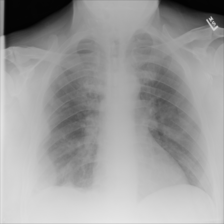

In [ ]:
Mass = list(data_dir.glob('Mass/*'))
PIL.Image.open(str(Mass[0]))

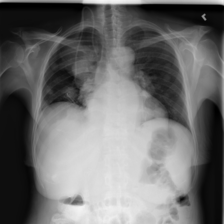

In [ ]:
PIL.Image.open(str(Mass[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Determine the image size

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.


## Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



**Configure the dataset for performance**

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

normalized_ds = normalized_ds.prefetch(tf.data.experimental.AUTOTUNE)

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

Found 104470 files belonging to 15 classes.
Using 83576 files for training.
0.027450982 0.95294124


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
 data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 104470 files belonging to 15 classes.
Using 20894 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Visualize the data

Here are the first nine images from the training dataset:

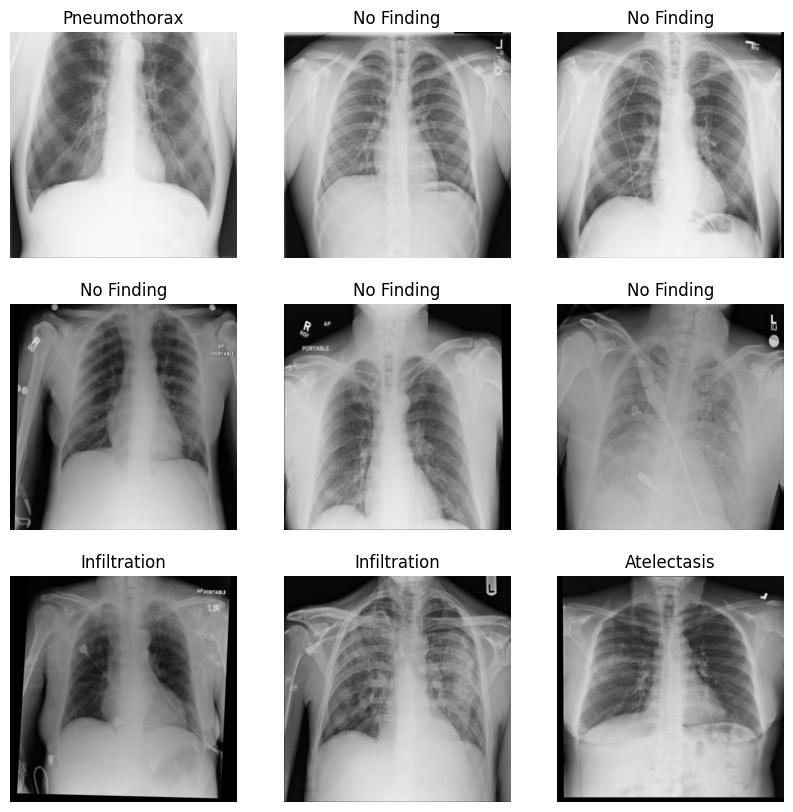

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 224, 224, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2612/2612 [==============================] - 196s 70ms/step - loss: 1.7829 - accuracy: 0.4829 - val_loss: 1.7273 - val_accuracy: 0.4944
Epoch 2/10
2612/2612 [==============================] - 186s 71ms/step - loss: 1.7197 - accuracy: 0.4892 - val_loss: 1.6686 - val_accuracy: 0.4999
Epoch 3/10
2612/2612 [==============================] - 175s 67ms/step - loss: 1.6610 - accuracy: 0.4969 - val_loss: 1.6279 - val_accuracy: 0.5046
Epoch 4/10
2612/2612 [==============================] - 173s 66ms/step - loss: 1.5690 - accuracy: 0.5130 - val_loss: 1.6094 - val_accuracy: 0.5089
Epoch 5/10
2612/2612 [==============================] - 174s 66ms/step - loss: 1.4338 - accuracy: 0.5450 - val_loss: 1.6483 - val_accuracy: 0.5137
Epoch 6/10
2612/2612 [==============================] - 174s 66ms/step - loss: 1.2709 - accuracy: 0.5885 - val_loss: 1.6350 - val_accuracy: 0.5175
Epoch 7/10
2612/2612 [==============================] - 171s 66ms/step - loss: 1.0938 - accuracy: 0.6406 - val_loss: 1

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

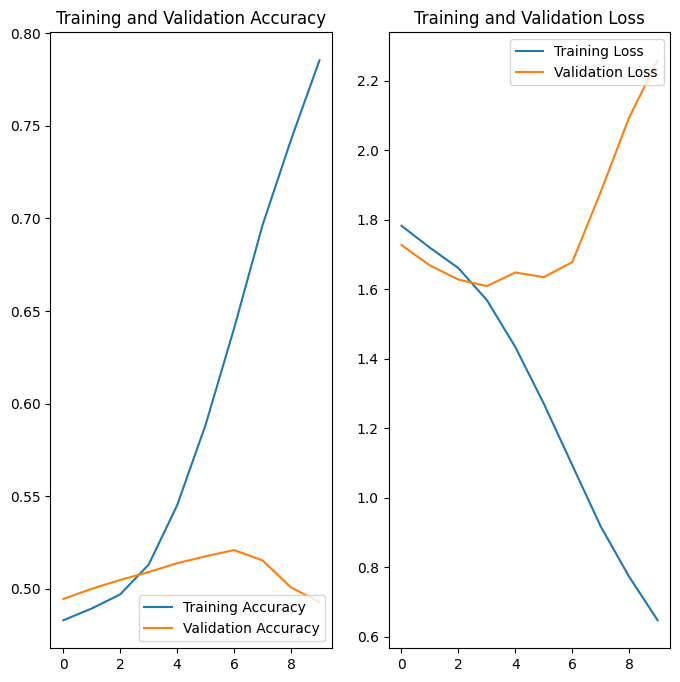

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins .

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting



When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

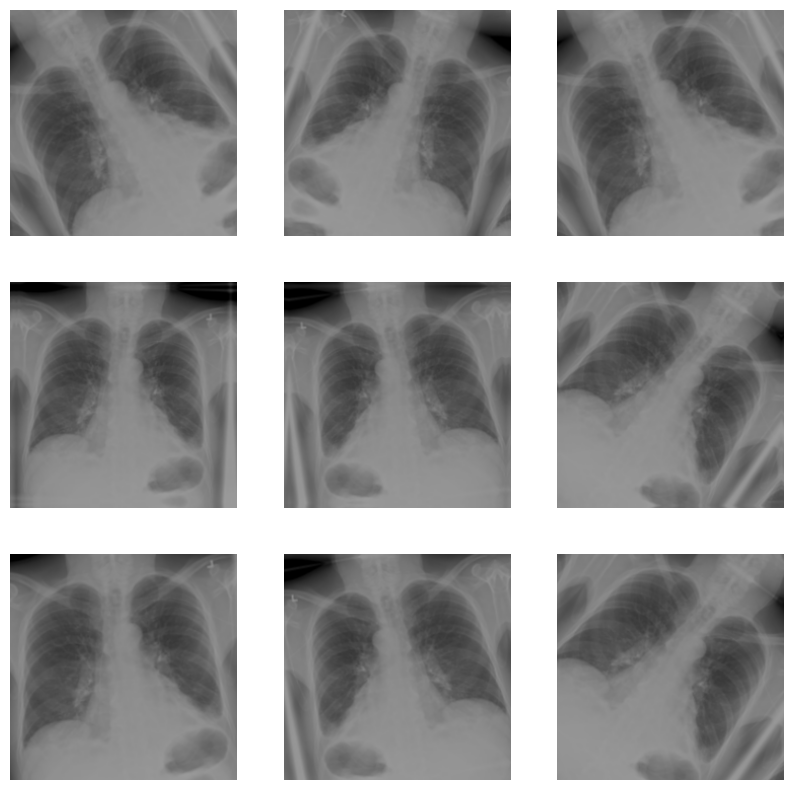

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2612/2612 [==============================] - 201s 76ms/step - loss: 1.8089 - accuracy: 0.4816 - val_loss: 1.7544 - val_accuracy: 0.4917
Epoch 2/20
2612/2612 [==============================] - 197s 75ms/step - loss: 1.7764 - accuracy: 0.4831 - val_loss: 1.7418 - val_accuracy: 0.4940
Epoch 3/20
2612/2612 [==============================] - 193s 74ms/step - loss: 1.7620 - accuracy: 0.4847 - val_loss: 1.7284 - val_accuracy: 0.4932
Epoch 4/20
2612/2612 [==============================] - 192s 73ms/step - loss: 1.7509 - accuracy: 0.4852 - val_loss: 1.7252 - val_accuracy: 0.4942
Epoch 5/20
2612/2612 [==============================] - 195s 75ms/step - loss: 1.7430 - accuracy: 0.4863 - val_loss: 1.7116 - val_accuracy: 0.4967
Epoch 6/20
2612/2612 [==============================] - 195s 75ms/step - loss: 1.7370 - accuracy: 0.4872 - val_loss: 1.7044 - val_accuracy: 0.4988
Epoch 7/20
2612/2612 [==============================] - 207s 79ms/step - loss: 1.7307 - accuracy: 0.4881 - val_loss: 1

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

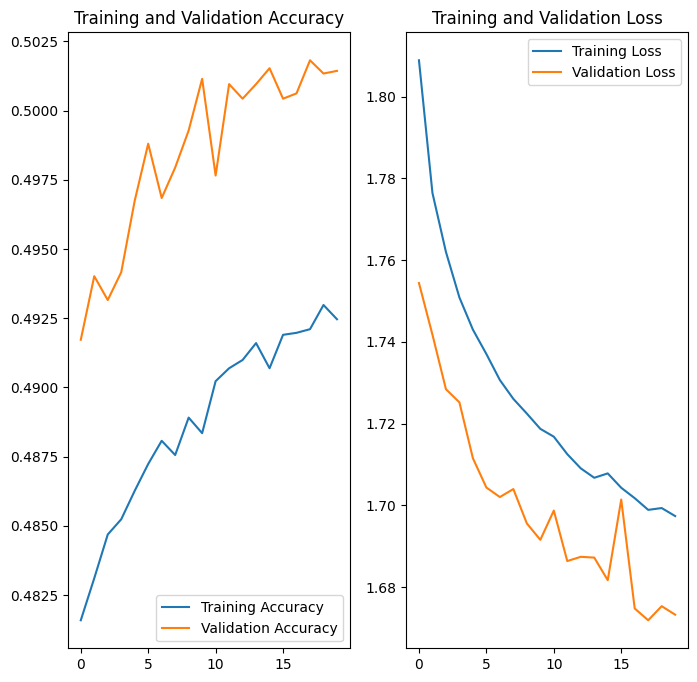

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('Trin_Model.h5')

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
#Chest_X_Ray_url = "https://www.pngegg.com/ar/png-cvwmd"
#Chest_X_Ray_path = tf.keras.utils.get_file('cvwmd', origin=Chest_X_Ray_url)

img = tf.keras.utils.load_img('/content/Dataset/test/Edema/00000032_007.png', target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to Effusion with a 21.82 percent confidence.
